In [41]:
from langgraph.graph import StateGraph,START,END
from typing import Annotated,Literal,TypedDict
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_openai import ChatOpenAI
import operator

In [2]:
import os

In [3]:
load_dotenv()

True

In [6]:
generator_llm=ChatOpenAI(
    model="mistralai/mistral-small-3.2-24b-instruct:free",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

In [7]:
evaluator_llm=ChatOpenAI(
    model="mistralai/mistral-small-3.2-24b-instruct:free",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

In [8]:
optimizer_llm=ChatOpenAI(
    model="mistralai/mistral-small-3.2-24b-instruct:free",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

In [42]:
#state
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal["approved","needs_improvement"]
    feedback:str
    iteration:int
    max_iteration:int 

    tweet_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]

In [18]:
from pydantic import BaseModel,Field

class TweetEvaluation_schema(BaseModel):
    evaluation:Literal["approved","needs_imporvement"]=Field(...,description="Final Evaluation Result")
    feedback:str=Field(...,description="feedback for the tweet")

In [19]:
structed_evaluator_llm=evaluator_llm.with_structured_output(TweetEvaluation_schema)

In [53]:
def generate_tweet(state:TweetState):

    #prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    #send to generator llm
    response=generator_llm.invoke(messages).content

    #return response
    return {'tweet':response,'tweet_history':[response]} 

In [54]:
def evaluate_tweet(state:TweetState):


    #prompt

    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]


    response=structed_evaluator_llm.invoke(messages)
    return {'evaluation':response.evaluation,'feedback':response.feedback,'feedback_history':[response]}


In [55]:
def optimize_tweet(state:TweetState):
     messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
     
     response=optimizer_llm.invoke(messages).content
     iteration=state['iteration']+1

     return {'tweet':response,'iteration':iteration,'tweet_history':[response]}

In [56]:
def route_evaluation(state:TweetState):

    if state['evaluation']=='approved' or state['iteration']>=state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvements'

In [57]:
graph=StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'needs_improvements':'optimize'})
graph.add_edge('optimize','evaluate')

workflow=graph.compile()

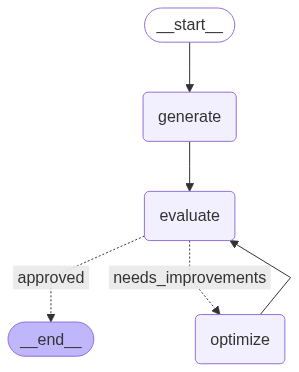

In [58]:
workflow

In [59]:
initial_state={
    'topic':'rahul gandhi',
    'iteration':1,
    'max_iteration':5
}

In [60]:
workflow.invoke(initial_state)

{'topic': 'rahul gandhi',
 'tweet': '"Rahul Gandhi trying to explain inflation: \'Imagine you have ₹100, then...\' Me: *pulls out my ₹500-onion meme* \'Ah, now you understand my pain.\'"',
 'evaluation': 'approved',
 'feedback': "This tweet is a solid mix of originality, humor, and relevance. The reference to '₹500-onion meme' contextualizes the discussion with a known Indian issue, making it relatable. The humor lies in the abrupt yet effective comparison, which is likely to resonate with those familiar with the meme. The tweet stops short at a point where the humor hits, avoiding any deflating lines. The format is concise and avoids the typical setup-punchline structure, making it less predictable. It's well within the 280-character limit and feels like it could easily be shared, increasing its virality potential.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['"Rahul Gandhi trying to explain inflation: \'Imagine you have ₹100, then...\' Me: *pulls out my ₹500-onion meme*